In [134]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seawater as sw
import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cf                 # import features
from pandas import ExcelWriter

fig_dir='C:/Users/gentemann/Google Drive/f_drive/docs/projects/misst-arctic/Saildrone/'

icefile='C:/Users/gentemann/Google Drive/f_drive/docs/projects/misst-arctic/Ice Present.xlsx'
DWfile='C:/Users/gentemann/Google Drive/f_drive/docs/projects/misst-arctic/DiurnalWarming Present.xlsx'

baddir='C:/Users/gentemann/Google Drive/f_drive/docs/projects/misst-arctic/'

data_dir = 'F:/data/cruise_data/saildrone/2019_arctic/post_mission_combined/'



## read in ice, diurnal warming, and surface coolingpresent file

This file is a combination of the NOAA ice file & own analysis of data based on STD of salinity and SST

In [135]:
ds = pd.read_excel(icefile, sheet_name='data',index_col=0)
ds_ice = ds.to_xarray()
ds = pd.read_excel(DWfile, sheet_name='warm',index_col=0)
ds_warm = ds.to_xarray()
ds = pd.read_excel(DWfile, sheet_name='cold',index_col=0)
ds_cool = ds.to_xarray()


## Read in all the cruise full data

- swap dims from obs to time
- I checked & time = for both trajectories

In [136]:
ds = xr.open_mfdataset(data_dir+'*.nc',combine='nested',concat_dim='trajectory').load()

#get rid of bad salinity values
ds_masked=ds.where(ds.SAL_SBE37_MEAN>20)
ds['SAL_SBE37_MEAN']=ds_masked['SAL_SBE37_MEAN']

xlon=ds.lon
time_offset_to_lmt=(xlon.data/360.)*24.*60
ds['tlmt']=xr.DataArray(np.ones((ds.lon.trajectory.size,ds.lon.time.size),dtype='datetime64[ns]'),dims={'trajectory','time'})
for i in range(2):
    ds['tlmt'][i,:]= ds.time.data+time_offset_to_lmt[i,:]*np.timedelta64(1,'m')# dt.timedelta(seconds=1)


In [137]:
ds.tlmt.dt.hour

<xarray.DataArray 'hour' (trajectory: 2, time: 215731)>
array([[11., 11., 11., ...,  7.,  7.,  7.],
       [11., 11., 11., ...,  7.,  7.,  7.]])
Coordinates:
  * time        (time) datetime64[ns] 2019-05-14T23:00:00 ... 2019-10-11T18:30:00
  * trajectory  (trajectory) object '1036' '1037'
    lat         (trajectory, time) float64 53.85 53.85 53.85 ... 53.84 53.84
    lon         (trajectory, time) float64 -166.6 -166.6 ... -166.6 -166.6

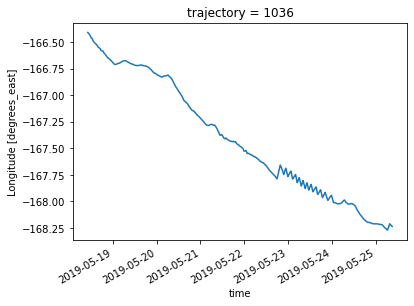

In [138]:
ds.lon[0,5000:15000].plot()


# Create ice mask based on photo/data

In [139]:
ice_mask=np.zeros(ds.TEMP_AIR_MEAN.shape)
ice_mask = xr.DataArray(ice_mask,coords=[ds.trajectory,ds.time],dims=['trajectory','time'],
                                           attrs={'long_name':'ice mask 1=ice'})
ds['ice_mask']=ice_mask
for iusv in range(2):
    ice =  ds_ice.sel(usv=int(ds.trajectory[iusv].data))
    ds_tem = ds.isel(trajectory=iusv)
    for i in range(ice.usv.size):
        print(iusv,ice.start_time[i].data)
        cond = (ds_tem.time>=ice.start_time[i]) & (ds_tem.time<=ice.stop_time[i])
        ds_tem.ice_mask[cond]=1
    ds['ice_mask'][iusv,:]=ds_tem.ice_mask

    
badfile=baddir+'Arctic_bad.xlsx'
ds_tem = pd.read_excel(badfile, sheet_name='warm',index_col=1)
ds_warm = ds_tem.to_xarray()
ds_tem = pd.read_excel(badfile, sheet_name='cold',index_col=1)
ds_cool = ds_tem.to_xarray()

tem=ds_warm
for i in range(tem.usv.size):
    tt=pd.to_datetime(str(tem.start_time[i].data),format='%Y-%m-%dT%H:%M:%S')
    tt64=np.datetime64(tt)
    tem.start_time[i]=tt64
    tt=pd.to_datetime(str(tem.stop_time[i].data),format='%Y-%m-%dT%H:%M:%S')
    tt64=np.datetime64(tt)
    tem.stop_time[i]=tt64
ds_warm=tem
tem=ds_cool
for i in range(tem.usv.size):
    tt=pd.to_datetime(str(tem.start_time[i].data),format='%Y-%m-%dT%H:%M:%S')
    tt64=np.datetime64(tt)
    tem.start_time[i]=tt64
    tt=pd.to_datetime(str(tem.stop_time[i].data),format='%Y-%m-%dT%H:%M:%S')
    tt64=np.datetime64(tt)
    tem.stop_time[i]=tt64
ds_cool=tem

tem_mask=np.zeros(ds.TEMP_AIR_MEAN.shape)
tem_mask = xr.DataArray(tem_mask,coords=[ds.trajectory,ds.time],dims=['trajectory','time'],
                                           attrs={'long_name':'Diurnal warming mask 1=warm'})
ds['warm_mask']=tem_mask
for iusv in range(2):
    tem =  ds_warm.sel(usv=int(ds.trajectory[iusv].data))
    ds_tem = ds.isel(trajectory=iusv)
    if tem.usv.size>1:
        for i in range(tem.usv.size):
            cond = (ds_tem.time>=tem.start_time[i]) & (ds_tem.time<=tem.stop_time[i])
            ds_tem.warm_mask[cond]=1
    else:
        cond = (ds_tem.time>=tem.start_time) & (ds_tem.time<=tem.stop_time)
        ds_tem.warm_mask[cond]=1       
    ds['warm_mask'][iusv,:]=ds_tem.warm_mask

tem_mask=np.zeros(ds.TEMP_AIR_MEAN.shape)
tem_mask = xr.DataArray(tem_mask,coords=[ds.trajectory,ds.time],dims=['trajectory','time'],
                                           attrs={'long_name':'surface cooling mask 1=cool'})
ds['cool_mask']=tem_mask
for iusv in range(2):
    tem =  ds_cool.sel(usv=int(ds.trajectory[iusv].data))
    ds_tem = ds.isel(trajectory=iusv)
    if tem.usv.size>1:
        for i in range(tem.usv.size):
            cond = (ds_tem.time>=tem.start_time[i]) & (ds_tem.time<=tem.stop_time[i])
            ds_tem.cool_mask[cond]=1
    else:
        cond = (ds_tem.time>=tem.start_time) & (ds_tem.time<=tem.stop_time)
        ds_tem.cool_mask[cond]=1       
    ds['cool_mask'][iusv,:]=ds_tem.cool_mask


0 2019-06-17T09:00:00.000000000
0 2019-06-22T16:30:00.000000000
0 2019-06-23T04:00:00.000000000
0 2019-07-17T23:30:00.000000000
0 2019-08-06T08:20:00.000000000
0 2019-08-06T20:20:00.000000000
0 2019-08-08T07:00:00.000000000
1 2019-06-17T08:00:00.000000000
1 2019-07-17T23:00:00.000000000
1 2019-08-04T00:00:00.000000000


In [140]:
ds.lon.time.size

215731

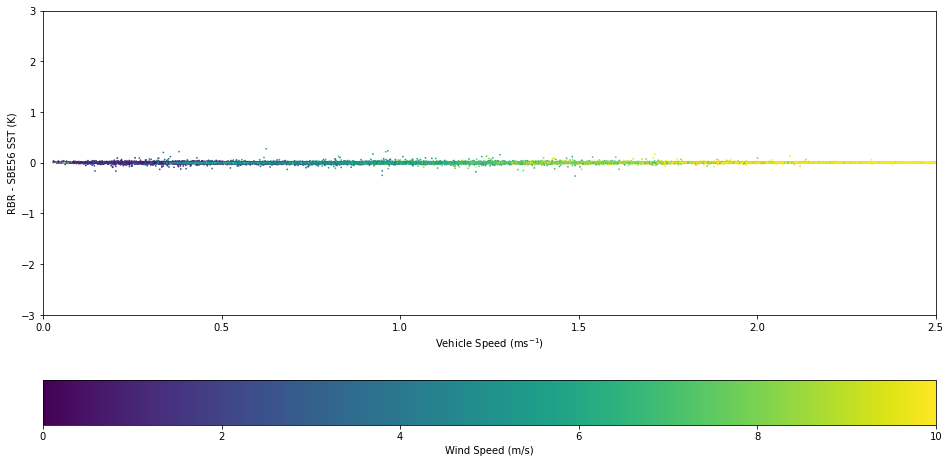

In [141]:
fig,(ax1) =plt.subplots(1,1,figsize=(16,8))
ds_masked = ds.where(ds.ice_mask==0)
ds_masked = ds_masked.where(ds.warm_mask==0)
ds_masked = ds_masked.where(ds.cool_mask==0)
tdif=ds_masked.TEMP_CTD_RBR_MEAN-ds_masked.sea_water_temperature_01_mean
for i in range(2):
    cs=ax1.scatter(ds.SOG_FILTERED_MEAN[i,:],tdif[i,:],c=ds.wspd_MEAN[i,:],s=.5,vmin=0,vmax=10)
ax1.set(xlabel='Vehicle Speed (ms$^{-1}$)', ylabel='RBR - SBE56 SST (K)')
ax1.set_xlim(0,2.5)
ax1.set_ylim(-3,3)
cbar = fig.colorbar(cs,orientation='horizontal',ax=ax1)
cbar.set_label('Wind Speed (m/s)')


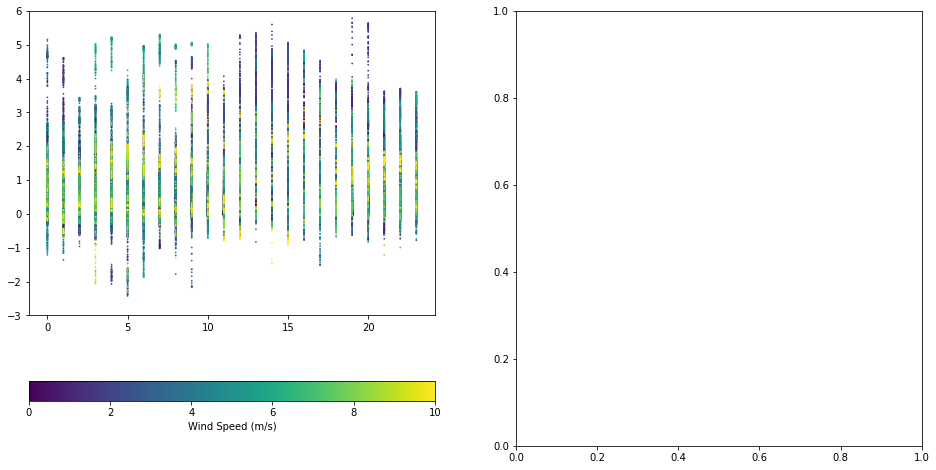

In [148]:
fig,(ax1,ax2) =plt.subplots(1,2,figsize=(16,8))
ds_masked = ds.where(ds.ice_mask==0)
#ds_masked = ds_masked.where(ds.warm_mask==0)
ds_masked = ds_masked.where(ds.cool_mask==0)
tdif=ds_masked.sea_water_temperature_00_mean-ds_masked.sea_water_temperature_06_mean
for i in range(2):
    cs=ax1.scatter(ds.tlmt.dt.hour[i,:],tdif[i,:],c=ds.wspd_MEAN[i,:],s=.5,vmin=0,vmax=10)
#ax1.set(xlabel='Vehicle Speed (ms$^{-1}$)', ylabel='RBR - SBE56 SST (K)')
#ax1.set_xlim(0,2.5)
ax1.set_ylim(-3,6)
cbar = fig.colorbar(cs,orientation='horizontal',ax=ax1)
cbar.set_label('Wind Speed (m/s)')
#fig.savefig(figure_output_dir+'figs/temp_sog_comparesbe56_ctds_data_filtered.png')

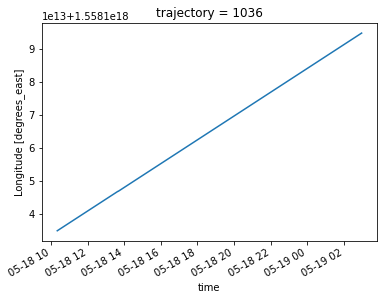

In [60]:
fig,(ax1,ax2) =plt.subplots(1,2,figsize=(16,8))
ds_masked = ds.where(ds.ice_mask==0)
ds_masked = ds_masked.where(ds.warm_mask==0)
ds_masked = ds_masked.where(ds.cool_mask==0)
tdif=ds_masked.sea_water_temperature_00_mean-ds_masked.sea_water_temperature_06_mean
for i in range(2):
    cs=ax1.scatter(ds.tlmt.dt.hour[i,:],tdif[i,:],c=ds.wspd_MEAN[i,:],s=.5,vmin=0,vmax=10)
#ax1.set(xlabel='Vehicle Speed (ms$^{-1}$)', ylabel='RBR - SBE56 SST (K)')
#ax1.set_xlim(0,2.5)
ax1.set_ylim(-3,6)
cbar = fig.colorbar(cs,orientation='horizontal',ax=ax1)
cbar.set_label('Wind Speed (m/s)')
#fig.savefig(figure_output_dir+'figs/temp_sog_comparesbe56_ctds_data_filtered.png')

In [ ]:
tem_mask=np.zeros(ds.TEMP_AIR_MEAN.shape)
tem_mask = xr.DataArray(tem_mask,coords=[ds.trajectory,ds.time],dims=['trajectory','time'],
                                           attrs={'long_name':'Diurnal warming mask 1=warm'})
ds['warm_mask']=tem_mask
for iusv in range(2):
    tem =  ds_warm.sel(usv=int(ds.trajectory[iusv].data))
    ds_tem = ds.isel(trajectory=iusv)
    if tem.usv.size>1:
        for i in range(tem.usv.size):
            cond = (ds_tem.time>=tem.start_time[i]) & (ds_tem.time<=tem.stop_time[i])
            ds_tem.warm_mask[cond]=1
    else:
        cond = (ds_tem.time>=tem.start_time) & (ds_tem.time<=tem.stop_time)
        ds_tem.warm_mask[cond]=1       
    ds['warm_mask'][iusv,:]=ds_tem.warm_mask
